In [20]:
import pandas as pd
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
def join_reviews(data, isPreprocessed=True):
    if (isPreprocessed):
        review_text = []
        reviews = (data['review'].apply(ast.literal_eval))
        review_strings = reviews.apply(' '.join)
        review_strings.apply(review_text.append)
    
    return review_text

def graph_word_cloud(data, isPreprocessed=True):
    if (isPreprocessed):
        review_lists = (data['review'].apply(ast.literal_eval))
        review_strings = review_lists.apply(' '.join)
        corpus = ' '.join(review_strings)
    else:
        corpus = data['review'].str.cat(sep=' ')
        
    word_cloud = WordCloud(width=1600, height=800, collocations=False).generate(corpus)
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
def stem_review(review):
    stemmer = PorterStemmer()
    stemmed_review = [stemmer.stem(token) for token in review]
    
    return stemmed_review
    
def get_tfidf_weights(data, vocab, isStemmed=False):
    if (isStemmed):
        stemmer = PorterStemmer()
        vocab = [stemmer.stem(word) for word in vocab]   
        
    vocab_dict = {vocab[i]: i for i in range(len(vocab))}
    
    corpus = join_reviews(data)
    vectorizer = TfidfVectorizer(vocabulary=vocab)
    X = vectorizer.fit_transform(corpus)

    feature_names = vectorizer.get_feature_names()
    inverse_document_frequency = vectorizer.idf_
    tf_idf_results = dict(zip(feature_names, inverse_document_frequency))
    return tf_idf_results

In [3]:
data = pd.read_csv('data/review_data.csv')
preprocessed_data = pd.read_csv('data/preprocessed_review_data.csv')

In [4]:
# data exploration
print("Columns: {0}\n".format(preprocessed_data.columns.values))
print("Total reviews: {0}\n".format(preprocessed_data.shape[0]))
print("Was recommended:\n{0}".format(preprocessed_data['voted_up'].value_counts()))

Columns: ['steam_id' 'review' 'timestamp_created' 'voted_up']

Total reviews: 20000

Was recommended:
True     19014
False      986
Name: voted_up, dtype: int64


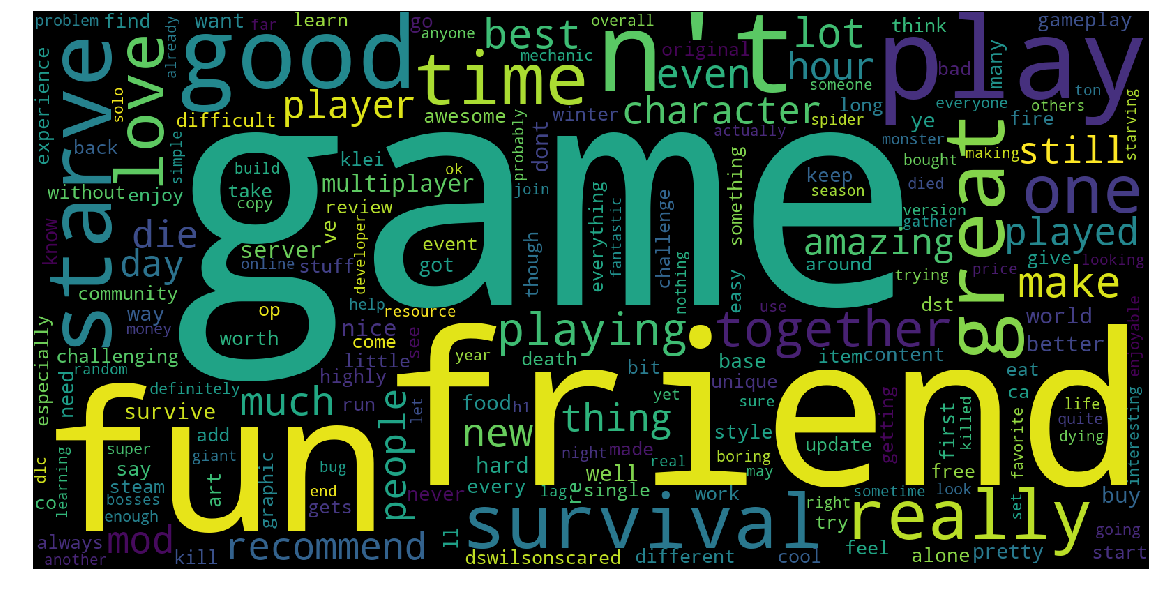

In [5]:
# wordcloud with preprocessing
graph_word_cloud(preprocessed_data)

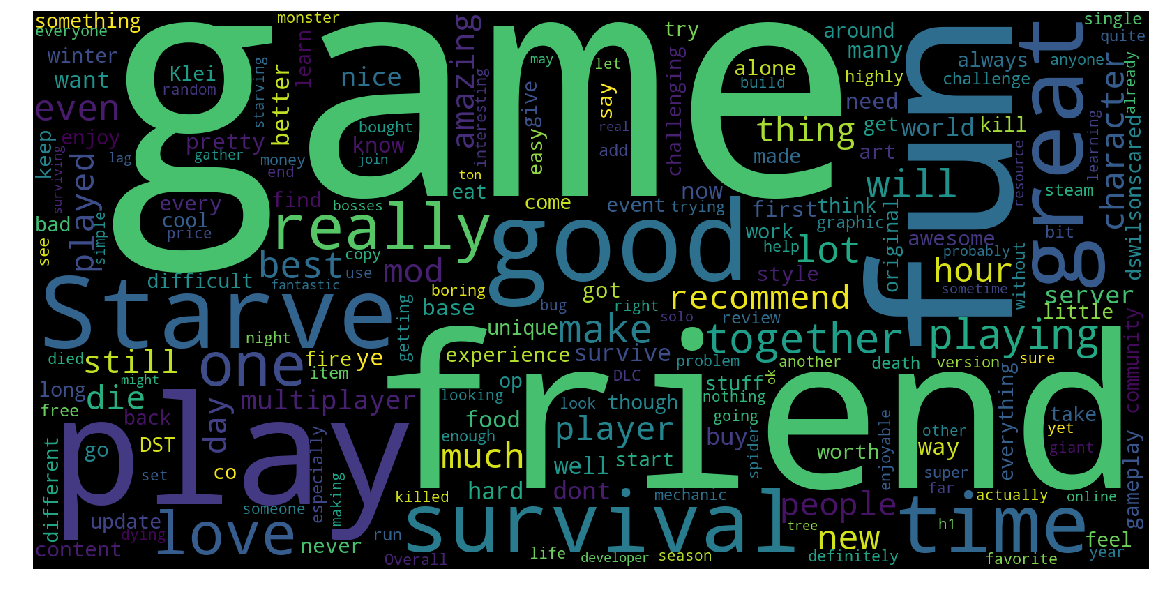

In [6]:
# wordcloud without preprocessing
graph_word_cloud(data, isPreprocessed=False)

In [33]:
characters = ['wilson', 'willow', 'wolfgang', 'wendy', 
              'wx', 'wx-78', 'wickerbottom', 'woodie', 'wes', 
              'maxwell', 'wigfrid', 'webber', 'warly', 
              'wormwood', 'winona', 'wortox', 'wurt']

character_weights = get_tfidf_weights(preprocessed_data, characters)
display(character_weights)

{'wilson': 6.760402824894637,
 'willow': 6.298367365298079,
 'wolfgang': 7.959098572119729,
 'wendy': 7.4378016484864435,
 'wx': 8.19548735018396,
 'wx-78': 10.90353755128617,
 'wickerbottom': 7.959098572119729,
 'woodie': 7.4378016484864435,
 'wes': 6.572804210999839,
 'maxwell': 7.76804333535702,
 'wigfrid': 7.6077006852818405,
 'webber': 6.729150281390533,
 'warly': 9.51724319016628,
 'wormwood': 8.264480221670912,
 'winona': 8.70631297394995,
 'wortox': 8.013165793390005,
 'wurt': 8.957627402230855}

In [ ]:
monsters = ['spiders', 'hounds', 'frogs', 'pigs', 'tentacles', 'merms', 'beargers', 'deerclops', 'dragonfly']

stemmed_data = preprocessed_data.copy()
stemmed_data['review'] = stemmed_data['review'].apply(ast.literal_eval)
stemmed_data['review'] = stemmed_data['review'].apply(stem_review)
stemmed_data['review'] = stemmed_data['review'].apply(str)

monster_weights = get_tfidf_weights(stemmed_data, monsters, isStemmed=True)
display(monster_weights)